# Metrics to investigate segmentation quality

When we apply a segmentation algorithm to an image, we can ask for good reason how good the segmentation result is. Actually, a common problem is that checking and improving the quality of segmentation results is often omitted and done rather by the the appearance of the segmentation result than by actually quantifying it. So lets look at different ways to achieve this quantification.

In [1]:
from skimage.io import imread, imshow
import napari
from the_segmentation_game import metrics as metrics_game
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay

For this, we will explore a dataset of the marine annelid Platynereis dumerilii from [Ozpolat, B. et al](https://doi.org/10.5281/zenodo.1063531) licensed by [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode). We will concentrate on a single timepoint. 

We already have ground truth (gt) annotations and segmentation result and are now just importing them.

In [2]:
gt = imread("../../data/Platynereis_tp7_channel1_rescaled(256x256x103)_gt.tif")
segmentation = imread("../../data/Platynereis_tp7_channel1_rescaled(256x256x103)_voronoi_otsu_label_image.tif")

For image visualization, we will use napari.

In [3]:
viewer = napari.Viewer()

Now we are adding gt and segmentation result as labels to our napari-viewer:

In [4]:
viewer.add_labels(gt, name = 'Ground truth')
viewer.add_labels(segmentation, name = 'Segmentation')

<Labels layer 'Segmentation' at 0x267db70ac40>

And change in the viewer from 2D to 3D view:

In [5]:
viewer.dims.ndisplay=3

In gallery view, you can see on the left now our segmentation result and the right our gt:

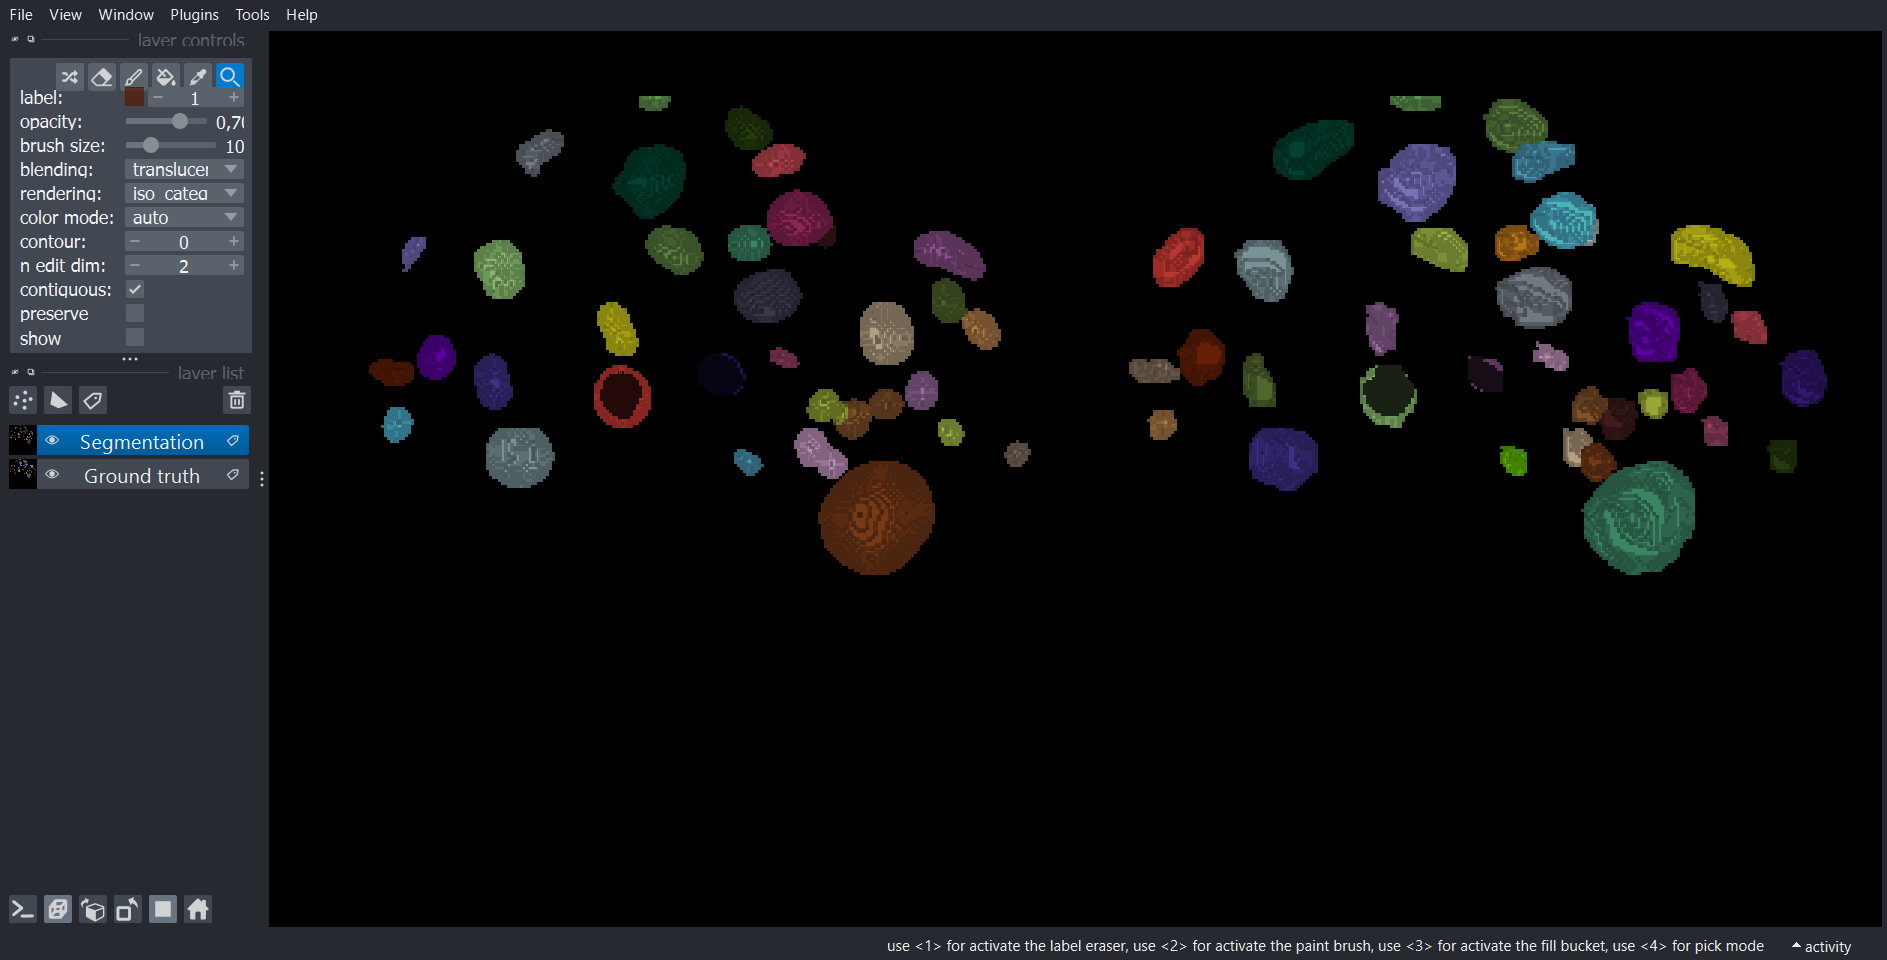

In [7]:
napari.utils.nbscreenshot(viewer)

For determining the quality of a segmentation result, we need a metric. There are different useful metrics:

## Jaccard index

The [__Jaccard index__](https://en.wikipedia.org/wiki/Jaccard_index) is a measure to investigate the similarity or difference of sample sets

In [the-segmentation-game](https://www.napari-hub.org/plugins/the-segmentation-game), we can find 3 different implementations of the Jaccard index:

The __sparse Jaccard Index__ measures the overlap lying between
0 (no overlap) and 1 (perfect overlap). Therefore, the ground truth label is compared
to the most overlapping segmented label. This value is then averaged over all annotated objects (see schematics).

In [6]:
# Jaccard index sparse
print('Jaccard index sparse: %.3f' % metrics_game.jaccard_index_sparse(gt,segmentation))

Jaccard index sparse: 0.555


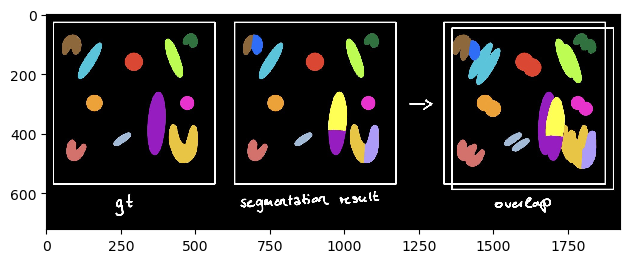

In [7]:
scheme_sparse = imread('schematics/Jaccard_index_sparse.jpg')
imshow(scheme_sparse)

When using the __binary Jaccard Index__, gt and segmentation result are first binarized into foreground (= everything annotated) and background (= rest). Next, the overlap between the binary images is computed. This can be used for comparing binary segmentation results, e.g. thresholding techniques. However, when we try to compare our gt and segmentation, we get:

In [8]:
# Jaccard index binary
print('Jaccard index binary: %.3f' % metrics_game.jaccard_index_binary(gt,segmentation))

Jaccard index binary: 0.709


The binary Jaccard index is way higher than the sparse Jaccard index because the outline of individual labels is not taken into account. Only the outline between fore- and background plays a role (see schematics below):

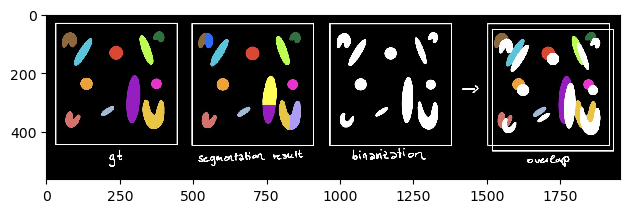

In [9]:
scheme_binary = imread('schematics/Jaccard_index_binary.jpg')
imshow(scheme_binary)

So for cases like ours we should use the sparse Jaccard index and not the binary Jaccard index.

# Terminology: What are TP, TN, FP, FN

We can also use different matrices which need __true positives (TP)__, __true negatives (TN)__, __false positives (FP)__ and __false negatives (FN)__. 

We want to compute these for a segmentation result. Therefore, we are treating the segmentation result as a two class thresholding-problem. The two classes are forground and background. To make this clearer, we binarize the gt and the segmentation result:

In [10]:
threshold = 1
gt_binary = gt >= threshold
segmentation_binary = segmentation >= threshold

In [11]:
viewer.add_labels(gt_binary, name = 'Binary ground truth')
viewer.add_labels(segmentation_binary, name = 'Binary segmentation result')

<Labels layer 'Binary segmentation result' at 0x26781f3c7f0>

Now we have labels only consisting of foreground (1) and background (0) which we can nicely see in napari (gallery view):

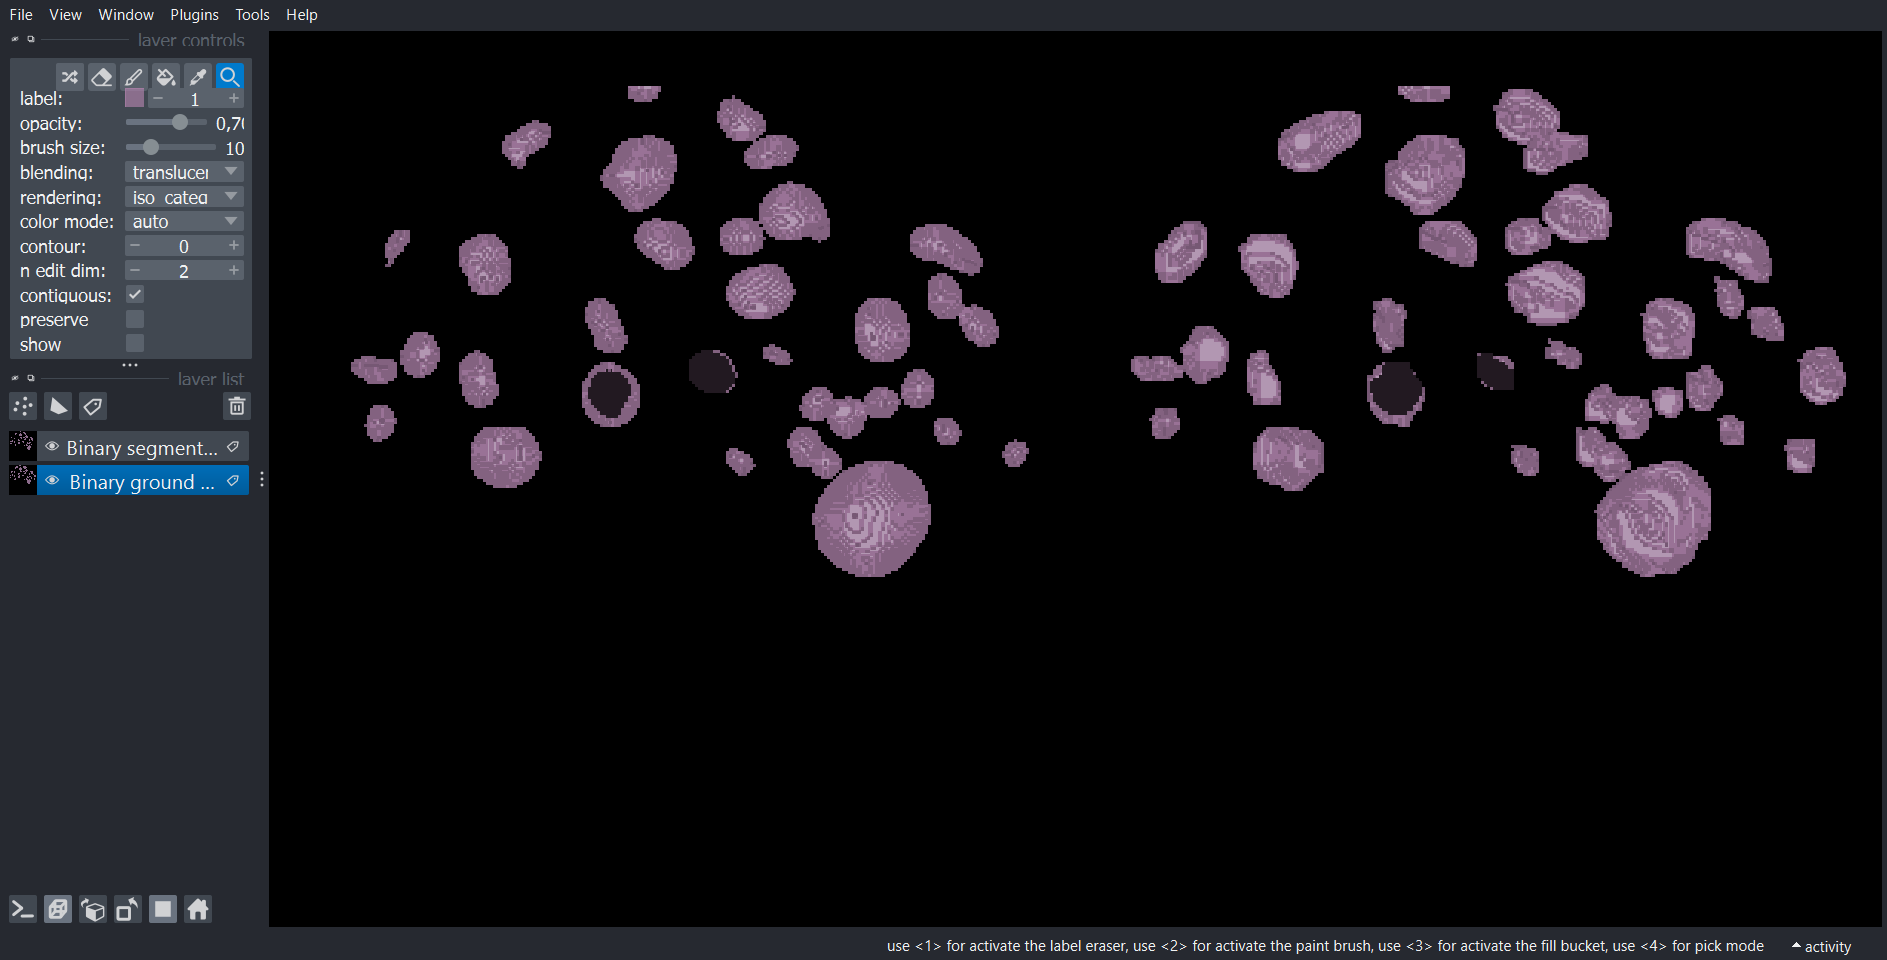

In [24]:
napari.utils.nbscreenshot(viewer)

Now what are TP, TN, FP and FN?
- __TP__ are pixels which are in gt and segmentation result foreground (1)
- __TN__ are pixels which are in gt and segmentation result background (0)
- __FP__ are pixels which are in gt background (0) but in the segmentation result foreground (1)
- __FN__ are pixels which are in gt foreground (1) but in the segmentation result background (0)

## Confusion matrix

These 4 can be nicely shown in a [__confusion matrix__](https://en.wikipedia.org/wiki/Confusion_matrix). Therefore, we will use [scikit-learn](https://scikit-learn.org/stable/index.html) (see also [metrics documentation](https://scikit-learn.org/stable/modules/model_evaluation.html))

We now want to plot the confusion matrix of the binary images. To be able to use the confusion matrix, we need to turn our image into a 1-dimensional array like this:

In [12]:
gt_1d = np.ravel(gt_binary)
segmentation_1d = np.ravel(segmentation_binary)

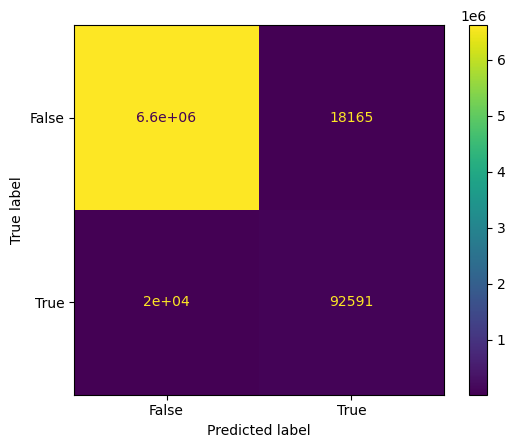

In [13]:
confusion_matrix = metrics.confusion_matrix(gt_1d,segmentation_1d)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

We can see that we mostly have __TN__ which means that our image consist mostly of background. 

# Accuracy, Precision, Recall, F1-Score

Now we are computing metrics which are based on the concept of TP, TN, FP and FN.

[__Accuracy__](https://en.wikipedia.org/wiki/Accuracy_and_precision) closely agrees with the accepted value. You basically ask: _How well did my segmentation go regarding my two different classes (foreground and background)?_

In [14]:
print('Accuracy: %.3f' % metrics.accuracy_score(gt_1d, segmentation_1d))
#In binary classification, this function is equal to the jaccard_score function

Accuracy: 0.994


This indicates that the segmentation algorithm performed correct in most instances.

[__Precision__](https://en.wikipedia.org/wiki/Accuracy_and_precision) shows similarities between the measurements. You basically ask: _How well did my segmentation go regarding the predicion of foreground objects?_

In [15]:
print('Precision: %.3f' % metrics.precision_score(gt_1d, segmentation_1d))

Precision: 0.836


This means that FP were lowering down the precision score.

[__Recall__](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers#Precision_and_recall) is the true positive rate (TPR) aka _Sensitivity_. You basically ask: _How many instances were correctly identified as foreground?_

In [16]:
print('Recall: %.3f' % metrics.recall_score(gt_1d, segmentation_1d))

Recall: 0.823


This means that out of the positive class, the model did perform well, but FN were lowering down the recall-score.

[__F1-Score__](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers#Precision_and_recall) is the harmonic mean between precision and recall score. You basically ask: _Can I find a compromise when choosing between precision and recall score?_ 
This results in a trade-off between high false-positives and false-negative rates.

In our case, precision and recall were very similar which means it is not really needed to compute the F1-Score. If we compute it we get a similar outcome:

In [17]:
print('F1 Score: %.3f' % metrics.f1_score(gt_1d, segmentation_1d))

F1 Score: 0.830


# Exercise

Now, we produce a gt and a segmentation result ourselves:

In [2]:
gt_new = np.array([[0, 1, 1],
               [0, 1, 0]])
segmentation_new = np.array([[0, 1, 0],
                       [0, 1, 1]])

Text(0.5, 1.0, 'segmentation result')

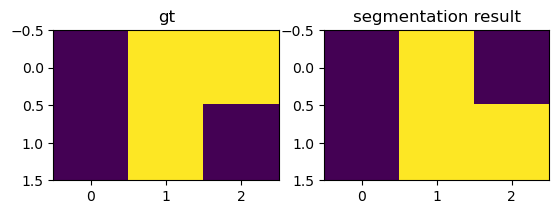

In [3]:
fig, ax = plt.subplots(1,2)

ax[0].imshow(gt_new)
ax[0].set_title('gt')
ax[1].imshow(segmentation_new)
ax[1].set_title('segmentation result')

As you can see, they are binary images consisting out of 0 (dark blue) and 1 (yellow). Can you compute a confusion matrix for this example? Try it out and interpret the results you get!